In [4]:
%load_ext autoreload
%autoreload 2

In [74]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
import glob as glob
from getSIDMdata_generator import get_tf_DataSet as getGenerators
import scienceplots
plt.style.use(["science"])
from copy import deepcopy as cp
from tqdm import tqdm

Objectives
----------
1. where is the model sensitive?

Conclusions
-----------



In [6]:
def get_best_model( image_generator, test_set, model_name='Inception', checkpoint_filepath="models" ):
    
    if os.path.isdir(checkpoint_filepath):
        print("Found Model")
        return tf.keras.models.load_model(checkpoint_filepath)
        
        
    num_classes = len(np.unique(test_set[1]))
    
    if model_name.lower() == 'simple':
        model = simpleCNN.getModel_ds(num_classes)
    elif model_name.lower() == 'dibare':
        model = mertens.DIBARE(input_shape=test_set[0][0].shape, classes=num_classes, bn_momentum=.0, 
                                FC1=0,FC2=0,feature_dropout=.33,num_layersA=1,num_layersB=1,num_layersC=1,leak=.03)
    elif model_name.lower() == 'inception':
        model = mertens.InceptionV4(input_shape=test_set[0][0].shape, bn_momentum=.0,classes=num_classes,
                                               feature_dropout=.33,num_layersA=1,num_layersB=1,num_layersC=1,leak=.03)

    else:
        raise ValueError("Model name not recognised")
    
    optimizer = tf.keras.optimizers.Adam( learning_rate=1e-3 ) 
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    
    history = model.fit(
      x=image_generator,
      validation_data=test_set,
      epochs=epochs, verbose=1, callbacks=[model_checkpoint_callback])
    
    return model
    
    

#### 1. Get the fiducial

In [12]:
histories = []
epochs=80
simulationNames = ['CDM','SIDM0.1','SIDM1']
nClasses = len(simulationNames)
all_channels = ['total','stellar','xray']
train, test  = getGenerators(augment_data=True, simulationNames=simulationNames,channels=all_channels,
                                                      allDataFile='pickles/binned_data_20.pkl')
checkpoint_filepath = 'models/inception/0'
model = get_best_model( train, test, checkpoint_filepath=checkpoint_filepath)

Found Model


In [85]:
#Now monte carlo each radial bin in the test set
xvec = np.arange(test[0].shape[1] ) - test[0].shape[1] / 2.
yvec = np.arange(test[0].shape[2] ) - test[0].shape[2] / 2.
xg, yg = np.meshgrid( xvec, yvec )
rgrid = np.sqrt(xg**2 + yg**2)
nBins = 20
rBins = np.linspace(0, 50., nBins+1)
bin_centres = (rBins[1:] + rBins[:-1])/2.
accuracy, accuracy_std = [], []

nMonte=5
fiducial_accuracy = model.evaluate(test[0], test[1])[1]
for iChannel in range(len(all_channels)):
    accuracy_channel, accuracy_channel_std = [], []
    for iBin in tqdm(range(nBins)):
        
        inBin = ( rgrid > rBins[iBin] ) & (rgrid < rBins[iBin+1])
    
        
        monted_acc = []
        this_test = cp(test)
        for iMonte in range(nMonte):
            for iTest in this_test[0][:,:,:,iChannel]:
                nElements = len(iTest[inBin])
                iTest[inBin] = np.random.uniform(0,1,nElements)
            importance = fiducial_accuracy /model.evaluate(this_test[0], this_test[1], verbose=0)[1] 
            monted_acc.append(importance)
            
            
        accuracy_channel.append(np.mean(monted_acc))
        accuracy_channel_std.append(np.std(monted_acc))
        
    accuracy.append(    accuracy_channel        )
    accuracy_std.append( accuracy_channel_std )

23/23 [==============================] - 2s 99ms/step - loss: 0.3853 - accuracy: 0.8250


100%|██████████████████████████████████████████████| 20/20 [02:55<00:00,  8.77s/it]


In [131]:
#Now monte carlo each radial bin in the test set
xvec = np.arange(test[0].shape[1] ) - test[0].shape[1] / 2.
yvec = np.arange(test[0].shape[2] ) - test[0].shape[2] / 2.
xg, yg = np.meshgrid( xvec, yvec )
rgrid = np.sqrt(xg**2 + yg**2)
nBins = 20
rBins = np.linspace(0, 50., nBins+1)
bin_centres = (rBins[1:] + rBins[:-1])/2.
profile = []

for iChannel in range(len(all_channels)):
    channel_profile = []
    data = np.mean(test[0][:,:,:,iChannel], axis=0)
    for iBin in tqdm(range(nBins)):
        
        inBin = ( rgrid > rBins[iBin] ) & (rgrid < rBins[iBin+1])
        
        channel_profile.append( np.sum( data[inBin]))
    profile.append(channel_profile)

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 18184.71it/s]


In [136]:
iChannel=0
data = np.mean(test[0][:,:,:,iChannel], axis=0)

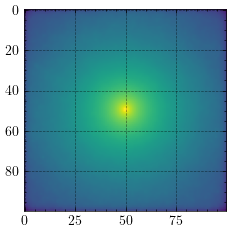

In [137]:
plt.imshow(np.log10(data))

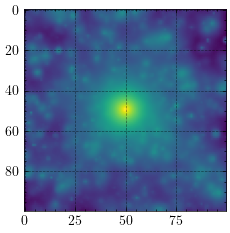

In [134]:
plt.imshow(np.log10(data))

#### Results

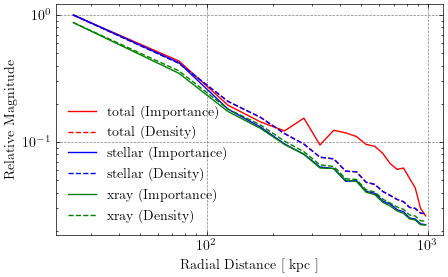

In [143]:
kpc_per_pixel = 20.
plt.figure(figsize=(5,3))
plt.xlabel('Radial Distance [ kpc ]')
plt.ylabel('Relative Magnitude')
nPixels = np.array([ len( rgrid[ ( rgrid > rBins[iBin] ) & (rgrid < rBins[iBin+1])]) for iBin in range(nBins)])
c = ['r','b','g','c','y','k']
for i, iChannel in enumerate(accuracy):
    normed_acc = iChannel/nPixels
    normed_pro = channel_profile[i]/nPixels
    
    if i ==0:
        norm = np.max(normed_acc)
    
    norm_pro = np.max(normed_pro)
        
    normed_acc /= norm
    normed_pro /= norm_pro / normed_acc[0]
    
    plt.errorbar(bin_centres*kpc_per_pixel, normed_acc, c=c[i], label="%s (Importance)" % all_channels[i])
    
    
    plt.errorbar(bin_centres*kpc_per_pixel,normed_pro, c=c[i], ls='--', label="%s (Density)" % all_channels[i])
    
    
plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.savefig("../plots/model_sensitivty.pdf")

In [117]:
accuracy[0]
        

[1.2305164889021132,
 1.2842389409109327,
 1.1505585196364094,
 1.1349361818410937,
 1.2952822684529992,
 1.9738158971098243,
 1.5383140331719178,
 2.071825410373025,
 2.470892040124024,
 2.336791755835514,
 2.4507189269198286,
 2.4586361341418788,
 2.458653108593148,
 2.1936369535642357,
 2.127653708981444,
 2.2706767183940557,
 2.088675861982665,
 1.7902571934538678,
 1.3440383569886647,
 1.1867205094244135]

In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

color=['r','g','b','c']

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelWithModel_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelWithModel_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModelSeparateChannels( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]
inputLayer = [ train_images[:,:,:,i][:,:,:,np.newaxis] for i in range(nChannels)]
testInputLayer = [ test_images[:,:,:,i][:,:,:,np.newaxis] for i in range(nChannels)]


history = model.fit(inputLayer, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(testInputLayer, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
train_images.shape

In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]


color=['r','g','b','c']

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannel_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannel_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=3)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

train_images[:, :, :, 1] =  train_images[:,:,:,2]
train_images = train_images[:, :, :, :2]


test_images[:, :, :, 1] =  test_images[:,:,:,2]
test_images = test_images[:, :, :, :2]

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelStellar_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelStellar_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=3)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelAll_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelAll_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelDepthWise_2_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelDepthWise_2_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getDepthWiseConvolution( inputShape, nClasses, nAttributes=0, \
                              momentum=0.9, finalLayer=256, learning_rate=1e-4)
model.summary()

nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)

